# Playing with CityJSON and pyvista

This is a notebook with experiments and demonstration of what we can do with `pyvista` and `pymesh`

First we do some imports:

In [2]:
import json
import numpy as np
import pyvista as pv
# from pymeshfix import MeshFix
import cityjson
import shapely
import math
from tqdm import tqdm
import os


def rpath(path):
    return os.path.expanduser(path)

Let's load some CityJSON file and have some minor boilerplate code:

In [4]:
float_formatter = "{:.3f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

# bag_tile = 7173

# models = {
#     "DenHaag": "",
#     "Helsinki": rpath("~/Dropbox/CityJSON/Helsinki/CityGML_BUILDINGS_LOD2_NOTEXTURES_672496x2.json"),
#     "Vienna": rpath("~/Dropbox/CityJSON/Vienna/Vienna_102081.json"),
#     "Montreal": rpath("~/Dropbox/CityJSON/Montreal/VM05_2009.json"),
#     "random": rpath("~/Downloads/random10_1.json"),
#     "Delfshaven": rpath("~/Dropbox/CityJSON/rotterdam/Version Old/3-20-DELFSHAVEN_uncompressed.json"),
#     "NYC": rpath("~/Dropbox/CityJSON/NewYork/NYCsubset.json"),
#     "bag_tile": rpath("3dbag_v210908_fd2cee53_5907.json")
# }

filename = rpath("C:/Users/Panagiotior/Desktop/SYNTHESIS/Data/3dbag_v210908_fd2cee53_5907/3dbag_v210908_fd2cee53_5907.json")

with open(filename) as file:
    cm = json.load(file)

if "transform" in cm:
    s = cm["transform"]["scale"]
    t = cm["transform"]["translate"]
    verts = [[v[0] * s[0] + t[0], v[1] * s[1] + t[1], v[2] * s[2] + t[2]]
            for v in cm["vertices"]]
else:
    verts = cm["vertices"]

# mesh points
vertices = np.array(verts)

## Load a city object in `pyvista`

Pick a city object to play with:

In [5]:
# obj = "GUID_816CA7F9-6357-447D-96E3-C74C5E47AABF_2" # Den Haag
# obj = list(cm["CityObjects"].keys())[0]
# obj = "UUID_LOD2_012092-314dbb09-4cfb-41f1-b664" # Vienna
# obj = "B-201391184551-8C37C51A0CFD" # Montreal building with open edge
# B-20139118400-95DC7A2E0FC0 Montreal
# obj = "B-201391183935-6B8EA1920647" # Montreal fails
# obj = "BID_df39af63-fd91-4239-98d5-cd63def98167" # Helsinki
# obj = "B-20131218142410-23B22495FF7A" # random
# obj = "{D892C834-12D5-4122-A816-ED49E0609DFF}" # Delfshaven
# obj = "UUID_LOD2_011530-cf0ab883-2798-437c-b530_1" # Vienna
# obj = "NL.IMBAG.Pand.0599100000601918-0" # 3338 - 102 roughness 3D
# obj = "NL.IMBAG.Pand.0344100000096859-0" # 7108 - high roughness 3D
# obj = "NL.IMBAG.Pand.0363100012148630-4" # 7108 - not that high elongation
# obj = "NL.IMBAG.Pand.0363100012173535-0" # 7173 - very low horizontal elongation
obj = "NL.IMBAG.Pand.0503100000002036-0" # added by adele

building = cm["CityObjects"][obj]

Loading and plotting the first geometry as a pure `pyvista` (no triangulation done). This sometimes doesn't work because VTK doesn't play well with complex polygons (anything over a quad):

In [15]:
dataset = cityjson.to_polydata(building["geometry"][0], vertices)
dataset = dataset.clean()

"""run this code to plot or the below one"""
# dataset.plot(show_edges=True)
"""alternatively plot with this"""
# p = pv.Plotter()
# p.add_mesh(dataset, color="yellow")
# p.show()


'alternatively plot with this'

Now let's load the object as a triangulated mesh (the triangulation is handled by us):

In [16]:
trimesh = cityjson.to_triangulated_polydata(building["geometry"][0], vertices).clean()
# trimesh.plot(show_edges=True)
"""or"""
# p = pv.Plotter()
# p.add_mesh(trimesh, color="yellow")
# p.show()


'or'

In [17]:
# trimesh.clean().plot()

BASIC ANALYSIS OF THE MESH

First, let's extract some feature edges

In [22]:
# trimesh.clean().extract_feature_edges().plot()

We can plot the edges alongside the mesh itself:

In [19]:
pv.set_jupyter_backend('ipyvtklink')
# p = pv.Plotter()

# p.add_mesh(trimesh)
# p.add_mesh(trimesh.extract_feature_edges(), color='black')

# p.show()

Let's see if there are any open edges, so if the volume is watertight. Any open edges will be shown as red lines:

In [21]:
edges = trimesh.extract_feature_edges(boundary_edges=True,
                           feature_edges=False,
                           manifold_edges=False)

# p = pv.Plotter()

# p.add_mesh(trimesh, opacity=1.0, show_edges=True)
# if trimesh.n_open_edges:
#     p.add_mesh(edges, color='red', line_width=10)

# p.add_title(f"{obj} {'is watertight' if trimesh.n_open_edges == 0 else f'has {trimesh.n_open_edges} open edges'}", 8)    

# p.show()

We can now voxelize the mesh. If this is not watertight, we have to force the library to avoid checking for surfaces and the result might be slightly incorrent:

In [30]:
clean = dataset.clean()
voxel = pv.voxelize(clean, density=clean.length/100, check_surface=False)
# voxel.plot(show_edges=True, text=f"[{obj}] Voxelized")

Let's compare the voxelized volume against the actual one. This is an indication of the validity of the object:

In [25]:
print(f"Voxel: {voxel.volume}")
print(f"Actual: {clean.volume}")

Voxel: 611.9989018404385
Actual: 558.7495673036893


We can extract the voxels centers to produce a grid of points for the mesh. This is slightly inconsistent, as some points are in and some outside of the object. This can be further cleaned later by computing the implicit distance of the points:

In [29]:
# p = pv.Plotter()

# p.add_mesh(voxel, opacity=0.2, show_edges=True, color='yellow')
# p.add_mesh(voxel.cell_centers(), color='black')
# p.add_mesh(clean, color='grey')
# p.add_mesh(pv.PolyData(np.mean(voxel.cell_centers().points, axis=0)), color='white')

# p.show()

The number of voxels is:

In [31]:
clean = trimesh.clean()
# clean.points -= np.mean(clean.points, axis=0)
voxel = pv.voxelize(clean, density=clean.length/100, check_surface=False)
voxel.n_cells

103296

## Compute the oriented bounding box

... or object-aligned bounding box, or minimum bounding rectangle etc.

We can compute this with a library we found on the web. The idea is that for buildings we can assume that an extruded 2D bounding box would work. So, let's do it in 2D first. This is the oriented bounding box:

In [33]:
from helpers.minimumBoundingBox import MinimumBoundingBox

obb_2d = MinimumBoundingBox([(p[0], p[1]) for p in dataset.clean().points])
obb_2d.area

71.77807433667886

Now let's extrude this with `pyvista`:

In [34]:
ground_z = np.min(dataset.clean().points[:, 2])
height = np.max(dataset.clean().points[:, 2]) - ground_z
box = np.array([[p[0], p[1], ground_z] for p in list(obb_2d.corner_points)])

obb = pv.PolyData(box).delaunay_2d()
pts = obb.points

t = np.mean(pts, axis=0)

# We need to move the points to the origin before extruding due to VTK's precision issues
obb.points = obb.points - t
obb = obb.extrude([0.0, 0.0, height])
obb.points = obb.points + t

C:\Users\Panagiotior\AppData\Local\Programs\Python\Python310\lib\site-packages\pyvista\core\filters\poly_data.py:2772: PyvistaFutureWarning: The default value of the ``capping`` keyword argument will change in a future version to ``True`` to match the behavior of VTK. We recommend passing the keyword explicitly to prevent future surprises.
  warnings.warn(


Let's see how the oriented bounding box fits with the object itself:

In [36]:
# p = pv.Plotter()

# p.add_mesh(obb, opacity=0.3)
# p.add_mesh(trimesh)

# p.show()

Sometimes the extruded volume produces a weird volume, so we have to fix it first:

In [31]:
#requires pymesh
# m = MeshFix(obb.clean().triangulate())
# m.repair()
# fixed_obb = m.mesh

# fixed_obb.volume

### Fully 3D oriented bounding box

There is a library to compute the bounding box in 3D, but it's not very reliable. This is a small test here:

In [36]:
# from pyobb.obb import OBB

# obb_full_3d = OBB.build_from_points(dataset.clean().points)

### 2D oriented bounding box from `shapely`

Similar to the previous library for 2D extrusion, we can compute the OBB using shapely. Let's extract a flattened version of the object and compute its *minimum rotated rectangle* (aka OBB):

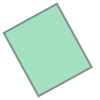

In [37]:
from cityjson import to_shapely

obb_2d = to_shapely(building["geometry"][0], vertices).minimum_rotated_rectangle
obb_2d

Now we can extrude (we wrote a function about this):

In [40]:
from geometry import extrude

ground_z = np.min(dataset.clean().points[:, 2])
roof_z = np.max(dataset.clean().points[:, 2])
obb = extrude(obb_2d, ground_z, roof_z)

# p = pv.Plotter()

# p.add_mesh(obb, show_edges=True, opacity=0.3)
# p.add_mesh(trimesh)

# p.show()

Let's compare the volumes:

In [40]:
#requires pymesh

# m = MeshFix(obb.clean().triangulate())
# m.repair()
# fixed_obb = m.mesh

# print(f"Volume: {clean.volume}")
# print(f"OBB: {obb.volume}")

# p = pv.Plotter()

# p.add_mesh(obb.clean(), show_edges=True, opacity=0.3)
# p.add_mesh(trimesh)

# p.show()

## Compute shape metrics

This is a banch of 2D and 3D metrics that can be used to describe a building:

In [45]:
# #need to install miniball

# from shapely.geometry import Point, MultiPoint, Polygon
# import math
# from tqdm.notebook import trange, tqdm
# # import miniball

# def create_grid_2d(shape, density):
#     """Return the grid for a given polygon"""
    
#     x_min, y_min, x_max, y_max = shape.bounds
#     x = np.arange(x_min, x_max, density)
#     y = np.arange(y_min, y_max, density)
#     x, y = np.meshgrid(x, y)
    
#     x = np.hstack(x)
#     y = np.hstack(y)
    
#     return [(x[i], y[i]) for i in range(len(x))]

# def create_grid_3d(mesh, density, check_surface=False):
#     """Returns the grid for a given mesh"""
#     voxel = pv.voxelize(mesh, density=density, check_surface=check_surface)
    
#     return voxel.cell_centers().points

# def distance(x, y):
#     """Returns the euclidean distance between two points"""
    
#     return math.sqrt(sum([math.pow(x[c] - y[c], 2) for c in range(len(x))]))

# def cohesion_2d(shape, grid=None, density=1):
#     """Returns the cohesion index in 2D for a given polygon"""
    
#     if grid is None:
#         grid = create_grid_2d(shape, density)
    
#     if isinstance(grid, list):
#         grid = MultiPoint(grid).intersection(shape)
    
#     d = 0
#     for pi in tqdm(grid.geoms, desc=f"Cohesion 2D (density={density})"):
#         for pj in grid.geoms:
#             if pi == pj:
#                 continue
            
#             d += pi.distance(pj)

#     n = len(grid.geoms)
#     return 0.9054 * math.sqrt(shape.area / math.pi) / (1 / (n * (n - 1)) * d)

# def cohesion_3d(mesh, grid=None, density=1, check_surface=False):
#     """Returns the cohesion index in 3D for a given mesh"""
    
#     if grid is None:
#         grid = create_grid_3d(density=density, check_surface=check_surface)
    
#     d = 0
#     for pi in tqdm(grid, desc=f"Cohesion 3D (density={density})"):
#         for pj in grid:
#             d += distance(pi, pj)
    
    
#     n = len(grid)
#     return 36 / 35 * math.pow(3 * mesh.volume / (4 * math.pi), 1/3) / (1 / (n * (n - 1)) * d)

# def proximity_2d(shape, density=1, grid=None):
#     """Returns the proximity index in 2D for a given polygon"""
    
#     if grid is None:
#         grid = create_grid_2d(shape, density)
    
#     if isinstance(grid, list):
#         grid = MultiPoint(grid).intersection(shape)
        
#     return grid
    
#     centroid = shape.centroid
    
#     return 2 / 3 * math.sqrt(shape.area / math.pi) / np.mean([centroid.distance(p) for p in grid])

# def proximity_3d(mesh, grid=None, density=1, check_surface=False):
#     """Returns the cohesion index in 3D for a given mesh"""
    
#     if grid is None:
#         grid = create_grid_3d(mesh, density=density, check_surface=check_surface)

#     centroid = np.mean(grid, axis=0)
    
#     # TODO: Verify the formula here
#     r = math.pow(3 * mesh.volume / (4 * math.pi), 1/3)

#     return (3 * r / 4) / np.mean([distance(centroid, p) for p in grid])

# def equal_volume_radius(volume):
#     """Returns the radius of the equal volume sphere"""
    
#     return math.pow(3 * volume / (4 * math.pi), 1/3)

# def equal_volume_sphere(mesh, position=(0, 0, 0)):
#     """Returns the sphere that has the same volume as the given mesh"""
    
#     r = math.pow(3 * mesh.volume / (4 * math.pi), 1/3)
    
#     return pv.Sphere(radius=r, center=position)

# def exchange_2d(shape):
#     """Returns the exchange index in 2D for a given polygon"""
    
#     r = math.sqrt(shape.area / math.pi)
    
#     eac = shape.centroid.buffer(r)
    
#     return shape.intersection(eac).area / shape.area

# def exchange_3d(mesh, evs=None, density=0.25, engine="igl"):
#     """Returns the exhange index in 3D for a given mesh
    
#     mesh: The pyvista mesh to evaluate
#     evs: The equal volume sphere (if provided speeds up the calculation)
#     density: If no evs is provided, it is used to create a grid to compute the center of mass
#     enginge: The engine for the boolean operations
#     """
    
#     if evs is None:
#         voxel = pv.voxelize(mesh, density=density)
#         grid = voxel.cell_centers().points

#         centroid = np.mean(grid, axis=0)
#         evs = equal_volume_sphere(mesh, centroid)
    
#     pm_mesh = to_pymesh(mesh)
#     pm_evs = to_pymesh(evs)
    
#     inter = pymesh.boolean(pm_mesh, pm_evs, operation="intersection", engine=engine)
    
#     return inter.volume / mesh.volume

# def spin_2d(shape, grid=None, density=1):
#     if grid is None:
#         grid = create_grid_2d(shape, density)
    
#     if isinstance(grid, list):
#         grid = MultiPoint(grid).intersection(shape)
    
#     centroid = shape.centroid
    
#     return 0.5 * (shape.area / math.pi) / np.mean([math.pow(centroid.distance(p), 2) for p in grid])

# def spin_3d(mesh, grid=None, density=1, check_surface=False):
#     """Returns the cohesion index in 3D for a given mesh"""
    
#     if grid is None:
#         voxel = pv.voxelize(mesh, density=density, check_surface=check_surface)
#         grid = voxel.cell_centers().points
    
#     centroid = np.mean(grid, axis=0)
    
#     r = math.pow(3 * mesh.volume / (4 * math.pi), 1/3)
#     # TODO: Calculate the actual formula here
#     return 3 / 5 * math.pow(r, 2) / np.mean([math.pow(distance(centroid, p), 2) for p in grid])

# def perimeter_index(shape):
#     return 2 * math.sqrt(math.pi * shape.area) / shape.length

# def circumference_index_3d(mesh):
#     return 4 * math.pi * math.pow(3 * mesh.volume / (4 * math.pi), 2 / 3) / mesh.area
    
# def depth_2d(shape, grid=None, density=1):
#     if grid is None:
#         grid = create_grid_2d(shape, density)
    
#     if isinstance(grid, list):
#         grid = MultiPoint(grid).intersection(shape)
        
#     return 3 * np.mean([p.distance(shape.boundary) for p in grid]) / math.sqrt(shape.area / math.pi)

# def depth_3d(mesh, grid=None, density=1, check_surface=False):
#     """Returns the depth index in 3D for a given mesh"""
    
#     if grid is None:
#         voxel = pv.voxelize(mesh, density=density, check_surface=check_surface)
#         grid = voxel.cell_centers()
        
#     dist = grid.compute_implicit_distance(mesh)
    
#     r = math.pow(3 * mesh.volume / (4 * math.pi), 1/3)
#     return 4 * np.mean(np.absolute(dist["implicit_distance"])) / r

# from polylabel import polylabel

# def largest_inscribed_circle(shape):
#     """Returns the largest inscribed circle of a polygon in 2D"""

#     centre, r = polylabel([list([list(c)[:2] for c in shape.boundary.coords])], with_distance=True)  # ([0.5, 0.5], 0.5)

#     lic = Point(centre).buffer(r)
    
#     return lic

# def largest_inscribed_sphere(mesh, grid=None, density=1, check_surface=False):
#     """Returns the largest inscribed sphere of a mesh in 3D"""
    
#     if grid is None:
#         voxel = pv.voxelize(mesh, density=density, check_surface=check_surface)
#         grid = voxel.cell_centers()
    
#     if not isinstance(grid, pv.PolyData):
#         grid = pv.PolyData(grid)
        
#     dist = grid.compute_implicit_distance(mesh)
    
#     # The largest inscribed circle's radius is the largest (internal) distance,
#     # hence the lowest value (as internal distance is negative)
#     lis_radius = np.min(dist["implicit_distance"])
#     lis_center = dist.points[np.where(dist["implicit_distance"] == lis_radius)][0]
    
#     return pv.Sphere(center=lis_center, radius=abs(lis_radius))

# def girth_2d(shape):
#     """Return the girth index in 2D for a given polygon"""
    
#     lic = largest_inscribed_circle(shape)
    
#     # Compute the radius as half the bounding box width
#     r = (lic.bounds[2] - lic.bounds[0]) / 2
    
#     return r / math.sqrt(shape.area / math.pi)

# def girth_3d(mesh, grid=None, density=1, check_surface=False):
#     """Return the girth index in 3D for a given mesh"""
    
#     lis = largest_inscribed_sphere(mesh,
#                                    grid=grid,
#                                    density=density,
#                                    check_surface=check_surface)
    
#     r = (lis.bounds[1] - lis.bounds[0]) / 2
#     r_evs = math.pow(3 * mesh.volume / (4 * math.pi), 1/3)
    
#     return r / r_evs

# def range_2d(shape):
#     """Returns the range index in 2D for a given polygon"""
    
#     from helpers.smallestenclosingcircle import make_circle

#     x, y, r = make_circle([c[:2] for c in  shape.boundary.coords])
    
#     return math.sqrt(shape.area / math.pi) / r

# import math

# def range_3d(mesh):
#     """Returns the range index in 3D for a given mesh"""
    
#     _, r2 = miniball.get_bounding_ball(mesh.points)
    
#     r_scc = math.sqrt(r2)
    
#     V = mesh.volume
    
#     return math.pow(3 * V / (4 * math.pi), 1/3) / r_scc

fp = to_shapely(building["geometry"][0], vertices)

# def print_stats(shape, mesh, density_2d=1, density_3d=2, check_surface=True):
#     """Computes and prints all stats for a geometry"""
    
#     # Compute the grid for the given mesh
#     voxel = pv.voxelize(mesh, density=density_3d, check_surface=check_surface)
#     grid = voxel.cell_centers().points
    
# #     print(f"Cohesion | {cohesion_2d(shape):.5f} | {cohesion_3d(mesh, grid):.5f}")
#     print(f"Proximity | {proximity_2d(shape, density=density_2d):.5f} | {proximity_3d(mesh, grid):.5f}")
#     print(f"Exchange | {exchange_2d(shape):.5f} | {exchange_3d(mesh, density=density_3d):.5f}")
#     print(f"Spin | {spin_2d(shape, density=density_2d):.5f} | {spin_3d(mesh, grid):.5f}")
#     print(f"Perimeter/Circumference | {perimeter_index(shape):.5f} | {circumference_index_3d(mesh):.5f} ")
#     print(f"Depth | {depth_2d(shape, density=density_2d):.5f} | {depth_3d(mesh, density=density_3d):.5f} ")
#     print(f"Girth | {girth_2d(shape):.5f} | {girth_3d(mesh, grid):.5f}")
#     print(f"Dispersion | {dispersion_2d(shape, density=density_2d):.5f} | {dispersion_3d(mesh, grid, density=density_3d):0.5f}")
#     print(f"Range | {range_2d(shape):.5f} | {range_3d(mesh):.5f}")
#     print(f"Roughness index | {roughness_index_2d(shape, density_2d)} | {roughness_index_3d(mesh, grid, density_2d)}")

# # print_stats(fp, clean)
# # print_stats(shapely.geometry.Point(0, 0).buffer(10), pv.Sphere(10), density_3d=pv.Sphere(10).length/50)
# # spin_3d(evs, density=0.25)
# # roughness_index_3d(dataset)
# # print_stats(fp, dataset)

In [41]:
# obb_pts = list(fp.minimum_rotated_rectangle.boundary.coords)

# S = Point(obb_pts[1]).distance(Point(obb_pts[0]))
# L = Point(obb_pts[2]).distance(Point(obb_pts[1]))

# if S > L:
#     L, S = S, L

# 1 - S / L

This is our own implementation on creating a grid that wraps the surface of a mesh:

In [48]:
# from helpers.geometry import surface_normal
# from shapely.geometry import Polygon

# def to_3d(points, normal, origin):
#     """Translate local 2D coordinates to 3D"""
    
#     x_axis, y_axis = axes_of_normal(normal)
  
#     return (np.repeat([origin], len(points), axis=0)
#         + np.matmul(points, [x_axis, y_axis]))    

# def axes_of_normal(normal):
#     """Returns an x-axis and y-axis on a plane of the given normal"""
#     if normal[2] > 0.001 or normal[2] < -0.001:
#         x_axis = [1, 0, -normal[0]/normal[2]];
#     elif normal[1] > 0.001 or normal[1] < -0.001:
#         x_axis = [1, -normal[0]/normal[1], 0];
#     else:
#         x_axis = [-normal[1] / normal[0], 1, 0];
    
#     x_axis = x_axis / np.linalg.norm(x_axis)
#     y_axis = np.cross(normal, x_axis)

#     return x_axis, y_axis

# def project_2d(points, normal):
#     origin = points[0]

#     x_axis, y_axis = axes_of_normal(normal)
     
#     return [[np.dot(p - origin, x_axis), np.dot(p - origin, y_axis)] for p in points]

# def create_surface_grid(mesh, density=1):
#     """Create a 2-dimensional grid along the surface of a 3D mesh"""
    
#     result = []
    
#     sized = mesh.compute_cell_sizes()
    
#     for i in range(mesh.n_cells):
#         if not mesh.cell_type(i) in [5, 6, 7, 9, 10]:
#             continue
        
#         pts = mesh.cell_points(i)
        
#         normal = surface_normal(pts)
        
#         pts_2d = project_2d(pts, normal)
#         poly_2d = Polygon(pts_2d)
        
#         grid = create_grid_2d(poly_2d, density)
#         grid = MultiPoint(grid).intersection(poly_2d)
        
#         if grid.is_empty:
#             continue
#         elif grid.geom_type == "Point":
#             grid = np.array(grid.coords)
#         else:
#             grid = np.array([list(p.coords[0]) for p in grid.geoms])
        
#         # TODO: Randomise the origin
#         result.extend(list(to_3d(grid, normal, pts[0])))
            
#     return result

# s_grid = pv.PolyData(create_surface_grid(trimesh, 1))

# p = pv.Plotter()

# p.add_mesh(dataset, opacity=0.9)
# # p.add_mesh(clean.extract_cells(82))
# p.add_mesh(s_grid)

# p.show()

In [42]:
pts = [[1138.221, 340727.568, 36.900],
 [1138.221, 340727.538, 36.900],
 [1138.221, 340727.508, 36.900]]

def surface_normal(poly):
    n = [0.0, 0.0, 0.0]

    for i, v_curr in enumerate(poly):
        v_next = poly[(i+1) % len(poly)]
        n[0] += (v_curr[1] - v_next[1]) * (v_curr[2] + v_next[2])
        n[1] += (v_curr[2] - v_next[2]) * (v_curr[0] + v_next[0])
        n[2] += (v_curr[0] - v_next[0]) * (v_curr[1] + v_next[1])
    
        if all([c == 0 for c in n]):
            raise ValueError("No normal. Possible colinear points!")

    normalised = [i/np.linalg.norm(n) for i in n]

    return normalised

surface_normal(pts)

ValueError: No normal. Possible colinear points!

In [51]:
#need handcalcs
# def dispersion_2d(shape, density=0.2):
#     """Returns the dispersion index in 2d for a given polygon"""
    
#     c = shape.centroid
#     b = shape.boundary
    
#     r = math.sqrt(shape.area / math.pi)
    
#     r_dev = 0
#     r_ibp = 0
#     for l in np.arange(0, b.length, density):
#         p = b.interpolate(l)
        
#         r_dev += abs(p.distance(c) - r)
#         r_ibp += p.distance(c)
    
#     return 1 - (r_dev / r_ibp)

# from handcalcs import handcalc

# # @handcalc()
# def dispersion_3d(mesh, grid, density=0.5):
#     """Returns the dispersion index in 3d for a given mesh"""
    
#     centroid = np.mean(grid, axis=0)
    
#     s_grid = create_surface_grid(mesh, density)
    
#     r = equal_volume_radius(mesh.volume)
    
#     r_dev = 0
#     r_ibp = 0
#     for p in s_grid:
#         d_i = distance(centroid, p)
#         r_dev += abs(d_i - r)
#         r_ibp += d_i

#     return 1 - (r_dev / r_ibp)

# # voxel = pv.voxelize(dataset, density=0.5, check_surface=False)
# # grid = voxel.cell_centers().points
# # dispersion_3d(dataset, grid)

In [53]:
# def roughness_index_2d(shape, density=0.2):
#     c = shape.centroid
#     b = shape.boundary
        
#     r_ibp = 0
#     for l in np.arange(0, b.length, density):
#         p = b.interpolate(l)
        
#         r_ibp += p.distance(c)
    
#     m_r = r_ibp / math.floor(b.length / density)
    
#     return 42.62 * math.pow(m_r, 2) / (shape.area + math.pow(shape.length, 2))

# def roughness_index_3d(mesh, grid, density=0.5):
#     centroid = np.mean(grid, axis=0)
        
#     s_grid = create_surface_grid(mesh, density)
        
#     r_ibp = 0
#     for p in s_grid:
#         d_i = distance(centroid, p)
#         r_ibp += d_i
    
#     m_r = r_ibp / len(s_grid)
    
#     return 48.735 * math.pow(m_r, 3) / (mesh.volume + math.pow(mesh.area, 3/2))

# mmm = dataset
# voxel = pv.voxelize(mmm, density=0.5, check_surface=False)
# grid = voxel.cell_centers().points
# roughness_index_3d(mmm, grid, density=0.2)

Compute the minimum bounding sphere of the building:

In [55]:
# import miniball
# C, r2 = miniball.get_bounding_ball(clean.clean().points)

# print(r2)
# print(clean.bounds)

# p = pv.Plotter()

# p.add_mesh(clean)
# # p.add_mesh(clean.extract_cells(82))
# p.add_mesh(pv.Sphere(radius=math.sqrt(r2), center=C), opacity=0.2)

# p.show()

Compute the largest inscribed sphere. This is based on creating a grid of a certain density and then picking the interior point of the largest distance from the boundaries (after computing the implicit distance):

In [57]:
# p = pv.Plotter()

# p.add_mesh(clean, opacity=0.2)
# p.add_mesh(largest_inscribed_sphere(clean, density=0.5))

# p.show()

## Playing with `pymesh`

Since `pyvista` is unreliable regarding boolean operations, this is how to convert to/from `pymesh` to do operations. `pymesh` is harder to install (see [here](https://pymesh.readthedocs.io/en/latest/installation.html)) but the result seems to be robust:

In [59]:
# import pymesh

# def to_pymesh(mesh):
#     """Returns a pymesh from a pyvista PolyData"""
#     v = mesh.points
#     f = mesh.faces.reshape(-1, 4)[:, 1:]

#     return pymesh.form_mesh(v, f)

# def to_pyvista(mesh):
#     """Return a PolyData from a pymesh"""
#     if len(mesh.vertices) == 0:
#         return pv.PolyData()
    
#     v = mesh.vertices
#     f = mesh.faces
    
#     f = np.hstack([[len(f)] + list(f) for f in mesh.faces])
    
#     return pv.PolyData(v, f, len(mesh.faces))

# evs = equal_volume_sphere(clean, position=np.mean(clean.points, axis=0))

# clean_pm = to_pymesh(clean)
# evs_pm = to_pymesh(evs)

# p = pv.Plotter()

# p.add_mesh(clean)
# p.add_mesh(evs)

# p.show()

In [60]:
# inter = pymesh.boolean(clean_pm, evs_pm, operation="intersection", engine="igl")

In [61]:
# p = pv.Plotter()

# p.add_mesh(evs, opacity=0.2, color='yellow')
# p.add_mesh(to_pyvista(inter), color='blue', show_edges=True)

# p.show()

# Checking common walls between buildings

In [44]:
building1 = cm["CityObjects"]["NL.IMBAG.Pand.0503100000019778-0"]

trimesh1 = cityjson.to_triangulated_polydata(building1["geometry"][0], vertices).clean()

building2 = cm["CityObjects"]["NL.IMBAG.Pand.0503100000018582-0"]

trimesh2 = cityjson.to_triangulated_polydata(building2["geometry"][0], vertices).clean()

p = pv.Plotter()

p.add_mesh(trimesh1, color="yellow")
p.add_mesh(trimesh2, color="red")

# trimesh1.extract_cells(range(27, 29))

p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [64]:
# m1 = to_pymesh(trimesh1)
# m2 = to_pymesh(trimesh2)

# wall = pymesh.boolean(m1, m2, operation="intersection", engine="igl")

# to_pyvista(wall)

In [65]:
# t1 = pv.PolyData([[0,0,0],[0,1,0],[1,0,0]], faces=[3, 0, 1, 2])
# t2 = pv.PolyData([[0,0,0],[0,1,0],[1,0,0]], faces=[3, 0, 1, 2])

# m1 = to_pymesh(trimesh1)
# m2 = to_pymesh(trimesh2)

# wall = pymesh.boolean(m1, m2, operation="intersection", engine="igl")

# to_pyvista(wall)

In [45]:
from helpers.geometry import surface_normal, project_2d, axes_of_normal
from shapely.geometry import MultiPolygon, Polygon
import scipy
from sklearn.cluster import AgglomerativeClustering

def is_on_plane(point, normal, origin):
    a, b, c, d = get_plane_params(normal, origin)
    
    x, y, z = point
    
    return a * x + b * y + c * z + d == 0

# intersect_surfaces(trimesh1, trimesh2)

def plane_params(normal, origin, rounding=2, absolute=True):
    """Returns the params (a, b, c, d) of the plane equation"""
    a, b, c = np.round_(normal, 3)
    x0, y0, z0 = origin
    
    d = -(a * x0 + b * y0 + c * z0)
    
    if rounding >= 0:
        d = round(d, rounding)
    
    return np.array([a, b, c, d])

def face_planes(mesh):
    # face normals compute face normals for meshes ? 
    return [plane_params(mesh.face_normals[i], mesh.cell_points(i)[0]) for i in range(mesh.n_cells)]

def project_mesh(mesh, normal, origin):
    p = []
    for i in range(mesh.n_cells):
        pts = mesh.cell_points(i)
        
        pts_2d = project_2d(pts, normal, origin)
        
        p.append(Polygon(pts_2d))
    
    return MultiPolygon(p).buffer(0)

def to_3d(polygon, normal, origin):
    xa, ya = axes_of_normal(normal)
    
    mat = np.array([xa, ya])
    pts = np.array(polygon.boundary.coords)
    
    return np.dot(pts, mat) + origin

def cluster_faces(data, threshold=0.1):
#     distance_matrix = np.asarray([
#         [abs_distance(data[first_index], data[second_index]) 
#              for first_index in range(len(data))] 
#                  for second_index in range(len(data))])
    ndata = np.array(data)
    
    dm1 = scipy.spatial.distance_matrix(ndata, ndata)
    dm2 = scipy.spatial.distance_matrix(ndata, -ndata)

    distance_matrix = np.minimum(dm1, dm2)

    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=threshold, affinity='precomputed', linkage='average').fit(distance_matrix)
    
    return clustering.labels_, clustering.n_clusters_

def cluster_meshes(meshes, threshold=0.1):
    """Clusters the faces of the given meshes"""
    
    n_meshes = len(meshes)
    
    # Compute the "absolute" plane params for every face of the two meshes
    planes = [face_planes(mesh) for mesh in meshes]
    mesh_ids = [[m for _ in range(meshes[m].n_cells)] for m in range(n_meshes)]
    
    # Find the common planes between the two faces
    all_planes = np.concatenate(planes)
    all_labels, n_clusters = cluster_faces(all_planes, threshold)
    areas = []
    
    labels = np.array_split(all_labels, [meshes[m].n_cells for m in range(n_meshes - 1)])
    
    return labels, n_clusters

def intersect_surfaces(meshes):
    """Return the intersection between the surfaces of multiple meshes"""
    
    n_meshes = len(meshes)
    
    areas = []
    
    labels, n_clusters = cluster_meshes(meshes)
    
    for plane in range(n_clusters):
        # For every common plane, extract the faces that belong to it
        idxs = [[i for i, p in enumerate(labels[m]) if p == plane] for m in range(n_meshes)]
                
        if any([len(idx) == 0 for idx in idxs]):
            continue
        
        msurfaces = [mesh.extract_cells(idxs[i]).extract_surface() for i, mesh in enumerate(meshes)]
                
        # Set the normal and origin point for a plane to project the faces
        origin = msurfaces[0].clean().points[0]
        normal = msurfaces[0].face_normals[0]
        
        # Create the two 2D polygons by projecting the faces
        polys = [project_mesh(msurface, normal, origin) for msurface in msurfaces]
        
        # Intersect the 2D polygons
        inter = polys[0]
        for i in range(1, len(polys)):
            inter = inter.intersection(polys[i])
        
        if inter.area > 0.001:
            if inter.type == "MultiPolygon":
                for geom in inter.geoms:
                    pts = to_3d(geom, normal, origin)
                    common_mesh = pv.PolyData(pts, faces=[len(pts)] + list(range(len(pts))))
                    common_mesh["area"] = [geom.area]
                    areas.append(common_mesh)
            else:
                pts = to_3d(inter, normal, origin)
                common_mesh = pv.PolyData(pts, faces=[len(pts)] + list(range(len(pts))))
                common_mesh["area"] = [inter.area]
                areas.append(common_mesh)
    
    return areas

def intersect_pairs(mesh, neighbours):
    return np.hstack([intersect_surfaces([mesh, neighbour]) for neighbour in neighbours])

t = np.mean(trimesh1.points, axis=0)
trimesh1.points -= t
trimesh2.points -= t

labels = cluster_meshes([trimesh1, trimesh2])
labels

pv.set_jupyter_backend('ipyvtklink')
# p = pv.Plotter()

# p.add_mesh(trimesh1, scalars=labels[0])
# p.add_mesh(trimesh2, scalars=labels[1])

# p.show()

intersect_surfaces([trimesh1, trimesh2])[0].plot()
# trimesh1.extract_cells(range(27, 29)).extract_surface().area

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [46]:
import rtree.index
import cityjson

def get_bbox(geom, verts):
    pts = np.array(cityjson.get_points(geom, verts))
    
    return np.hstack([[np.min(pts[:, i]), np.max(pts[:, i])] for i in range(np.shape(pts)[1])])

def generator_function(cm, verts):
    for i, objid in enumerate(cm["CityObjects"]):
        obj = cm["CityObjects"][objid]
        xmin, xmax, ymin, ymax, zmin, zmax = get_bbox(obj["geometry"][0], verts)
        yield (i, (xmin, ymin, zmin, xmax, ymax, zmax), objid)

p = rtree.index.Property()
p.dimension = 3
r = rtree.index.Index(generator_function(cm, vertices), properties=p)

ModuleNotFoundError: No module named 'rtree'

In [88]:
def plot_meshes(meshes, **kargs):
    p = pv.Plotter(**kargs)
    
    p.add_mesh(meshes[0], color="red")
    for mesh in meshes[1:]:
        p.add_mesh(mesh)
    
    p.show()

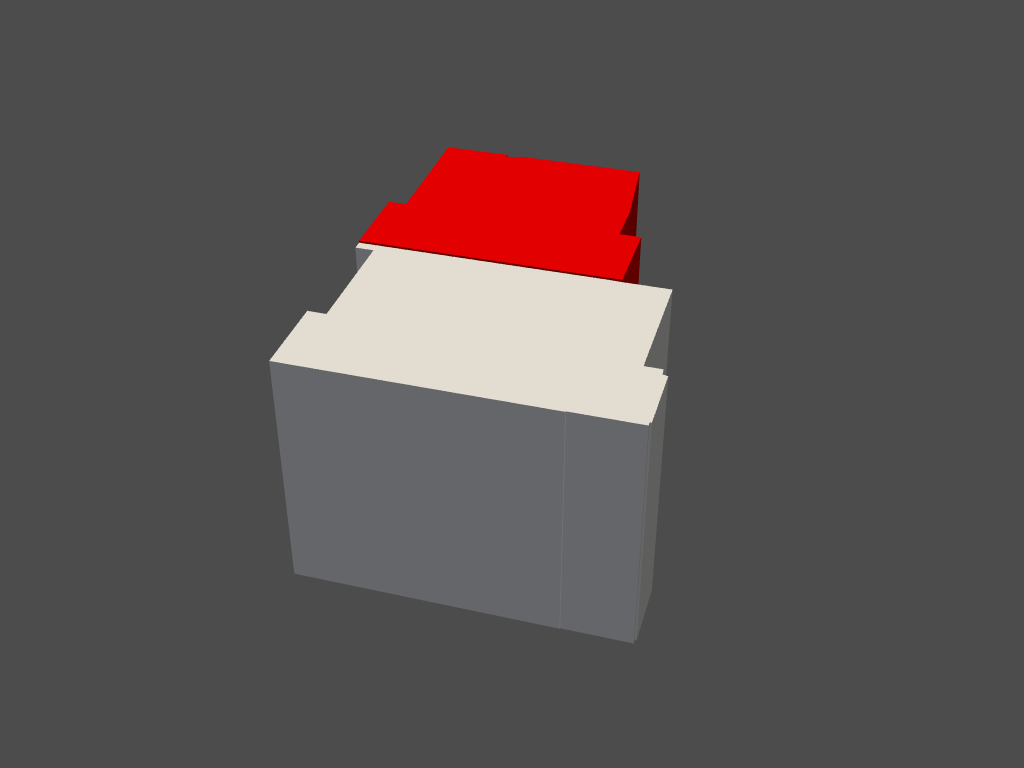

In [89]:
mainid = "NL.IMBAG.Pand.0503100000002036-0"

xmin, xmax, ymin, ymax, zmin, zmax = get_bbox(cm["CityObjects"][mainid]["geometry"][0], verts)
objids = [n.object for n in r.intersection((xmin, ymin, zmin, xmax, ymax, zmax), objects=True) if n.object != mainid]

main_mesh = cityjson.to_triangulated_polydata(cm["CityObjects"][mainid]["geometry"][0], vertices).clean()
meshes = [cityjson.to_triangulated_polydata(cm["CityObjects"][objid]["geometry"][0], vertices).clean() for objid in objids]

t = np.mean(main_mesh.points, axis=0)

main_mesh.points -= t
for mesh in meshes:
    mesh.points -= t

plot_meshes([main_mesh] + meshes)

In [90]:
walls = intersect_pairs(main_mesh, meshes)

In [91]:
area_pv = sum([wall.triangulate().area for wall in walls])
area_2d = sum(wall["area"][0] for wall in walls)

print(f"{area_pv} - {area_2d}")

73.74503056346961 - 73.74502896499408


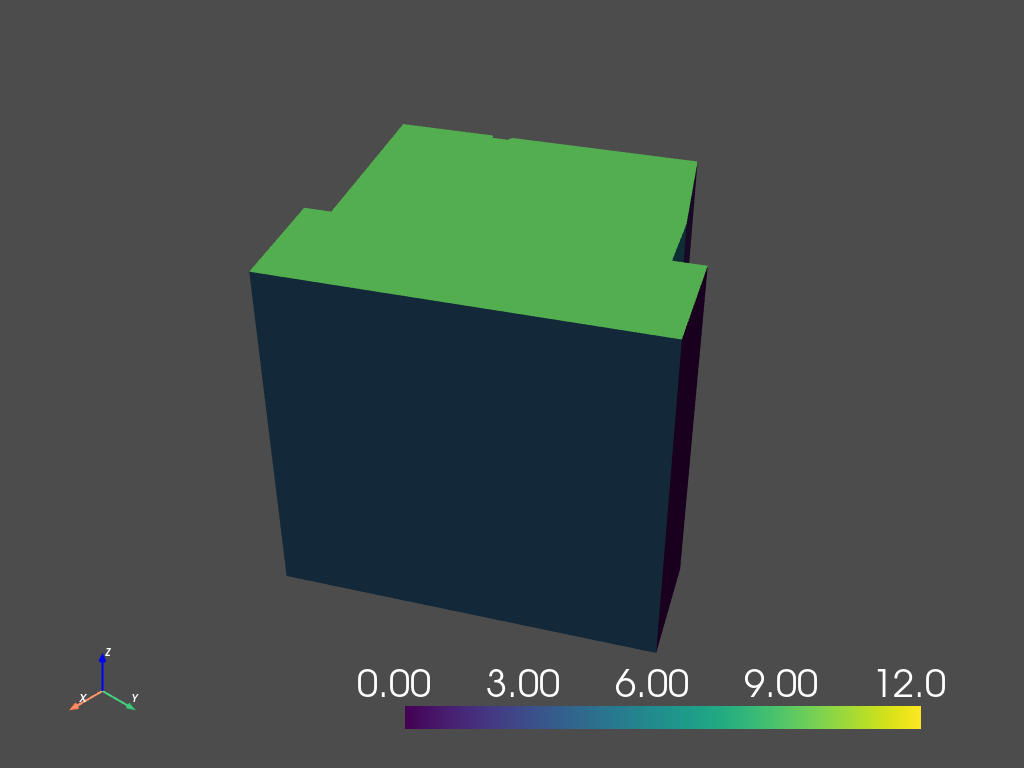

In [94]:
main_mesh.plot(scalars=cluster_meshes([main_mesh])[0])

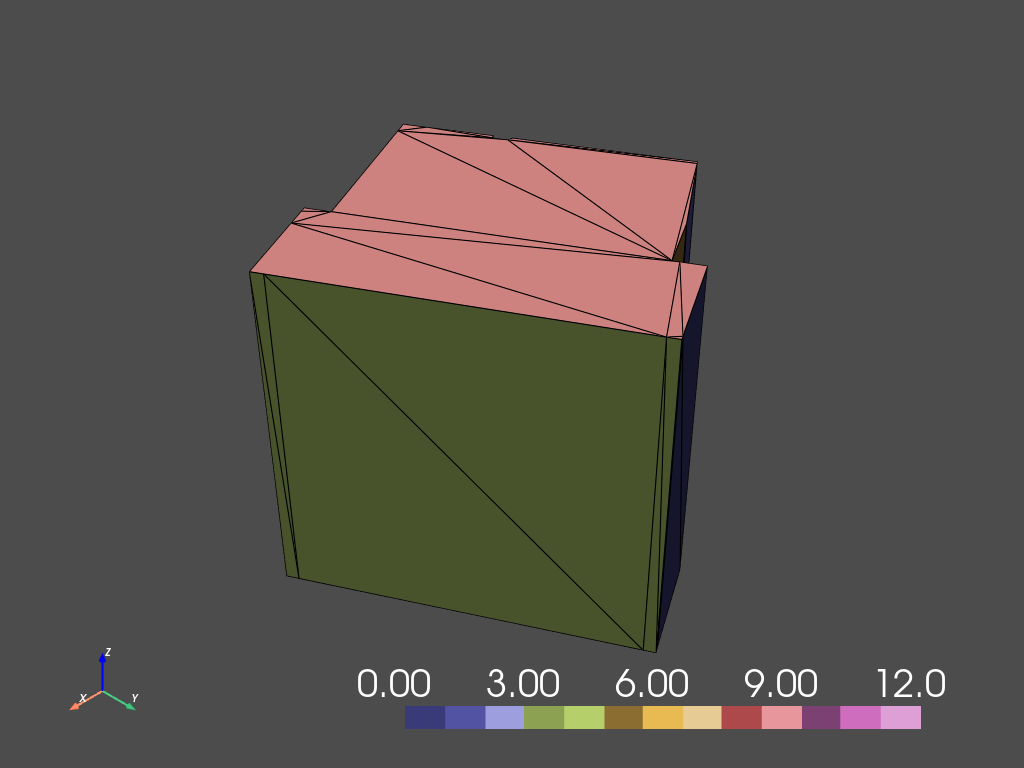

In [97]:

import numpy as np
import math

def distance(x, y):
    """Returns the euclidean distance between two points"""
    
    return math.sqrt(sum([math.pow(x[c] - y[c], 2) for c in range(len(x))]))

def abs_distance(x, y):
    """Returns the minimum absolute distance"""
    
    return min(distance(x, y), distance(x, [-e for e in y]))

t = np.mean(main_mesh.points, axis=0)
main_mesh.points -= t



labels, n_clusters = cluster_faces(face_planes(main_mesh))
import matplotlib.pyplot as plt
boring_cmap = plt.cm.get_cmap("tab20b", n_clusters)
main_mesh.plot(scalars=labels, show_edges=True, cmap=boring_cmap)

main_mesh.save("cluster.vtk")

In [98]:
import time

start = time.time()

cluster_meshes(meshes)

end = time.time()
print(end - start)

0.0494847297668457


In [99]:
start = time.time()

labels, n_clusters = cluster_faces(face_planes(main_mesh))

end = time.time()
print(end - start)

0.0331876277923584


In [100]:
data = np.array(face_planes(main_mesh))

dm1 = scipy.spatial.distance_matrix(data, data)
dm2 = scipy.spatial.distance_matrix(data, -data)

np.minimum(dm1, dm2)

array([[0.000, 0.000, 0.000, ..., 2.000, 2.000, 2.000],
       [0.000, 0.000, 0.000, ..., 2.000, 2.000, 2.000],
       [0.000, 0.000, 0.000, ..., 2.000, 2.000, 2.000],
       ...,
       [2.000, 2.000, 2.000, ..., 0.000, 0.000, 0.000],
       [2.000, 2.000, 2.000, ..., 0.000, 0.000, 0.000],
       [2.000, 2.000, 2.000, ..., 0.000, 0.000, 0.000]])